# Neural Architectures (VGG19 & ResNet50) vs AutoKeras

In class, we have learned about various groundbreaking Neural Architectures, and how they are designed and developed with unique model arrangements that give them their characteristic performance. As we began to read more into these models and try out some initial implementations ourselves, we realized that training functional models, even for standard datasets such as cifar10, may take days or even weeks! As much as we would love to take on the challenge of waiting a day per NN to know if our model built itself and compiled correctly, we decided to look at if there are any more intelligent ways to investigate the problems. This stumbled us upon tensorflow's bulit-in neural architecture functions from many of the prolific papers we summarized in class (https://www.tensorflow.org/api_docs/python/tf/keras/applications). These functions are origionally catered to the imagenet dataset, but with a concept called "transfer learning" we can use these proven and well recognized models on a new dataset (of different dimentions) such as our friend cifar10. After spending time reading into "transfer learning" and connecting the dots with how we might choose to implement it, we came up with the following questions that lead to this part of our bi-weekly investigation.
1. How much time will it save us to morph these pre-established neural architectures and weightings into functional models for a dataset of our choosing?
2. How effective is TensorFlow's AutoML feature (autokeras) relative to implementing the well-recognized architectures?
3. In what case would we use these pre-established neural architectures, AutoKeras, or our own convolutional NN as we have been doing in previous weeks of the class (interestingly enough we did find an example where AutoML was less effective than the author implementing their own architecture https://www.pyimagesearch.com/2019/01/07/auto-keras-and-automl-a-getting-started-guide/)?

## Implementation of Trasfer Learning using VGG19 and ResNet50 to Cifar10
Using the well-explained tutorial found at: https://www.kaggle.com/adi160/cifar-10-keras-transfer-learning, we will implement transfer learning from imagenet data to cifar10 in tensorflow with VGG19 and ResNet50 network architecture models. VGG19 is the VGG method we have implemented before with 19 layers and Resnet50 is 50 layers of residual units, which allows us to add more layers onto the model without loss in accuracy.

In [38]:
# Package initializations
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [37]:
from tensorflow.keras import Sequential
from tensorflow.keras.applications import VGG19,ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout #Still need these
from tensorflow.keras.utils import to_categorical

We will still need to import keras libraries such as Flatten, Desne, BatchNorm... etc becuase even though VGG19 and ResNet50 come already trained to imagenetdata, when we transfer their models, we will need to redimention their output down to 10 for cifar10, which will require some additions to the model and some training on those additions.

In [3]:
from tensorflow.keras.datasets import cifar10
#import and split data
(x_train,y_train),(x_test,y_test)=cifar10.load_data()

In [4]:
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.3)
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 1))
((15000, 32, 32, 3), (15000, 1))
((10000, 32, 32, 3), (10000, 1))


In [5]:
#Concept used the the tutorial here. The to_categorial converts the data into binary class values.

#One hot encode the labels.Since we have 10 classes we should expect the shape[1] of y_train,y_val and y_test to change from 1 to 10

y_train=to_categorical(y_train)
y_val=to_categorical(y_val)
y_test=to_categorical(y_test)

In [6]:
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))


((35000, 32, 32, 3), (35000, 10))
((15000, 32, 32, 3), (15000, 10))
((10000, 32, 32, 3), (10000, 10))


In [7]:
#Data Augmentation Function instances of the ImageDataGenerator class
train_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip=True,
                                    zoom_range=.1 )
val_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip=True,
                                    zoom_range=.1)
test_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip= True,
                                    zoom_range=.1) 
train_generator.fit(x_train) 
val_generator.fit(x_val)
test_generator.fit(x_test)

In [9]:
'''Learning Rate Annealer: The learning rate can be modified after a set number of epochs or after a certain condition is met. We will use the latter and change the learning rate if 
the validation error does not reduce after a set number of epochs. To do this we will use the patience parameter.'''

lrr= ReduceLROnPlateau(
                       monitor='val_acc', #Metric to be measured
                       metrics=['val_acc'],
                       factor=.01, #Factor by which learning rate will be reduced
                       patience=3,  #No. of epochs after which if there is no improvement in the val_acc, the learning rate is reduced
                       min_lr=1e-5) #The minimum learning rate 

Everything is initialized to now call the VGG19 and ResNet50 pre-established models into place. The input_shape can match that of cifar10, and we will end up restructuring the output back to 10 as mentioned before. However, the pre-trained weights from the origional imagenet must be used. The ResNet50 architecture is deeper. As we learned in class and in the paper Tan, Mingxing, and Quoc et al., there is an optimal balance between deepness, wideness, and resolution, however it is anticipated that with this considered ResNet50 will be more accurate from depth.

In [10]:
base_model_1 = VGG19(include_top=False,weights='imagenet',input_shape=(32,32,3),classes=y_train.shape[1])

base_model_2 = ResNet50(include_top=False,weights='imagenet',input_shape=(32,32,3),classes=y_train.shape[1])

In [11]:
model_1= Sequential()
model_1.add(base_model_1) 
model_1.add(Flatten()) #Since the output before the flatten layer is a matrix we have to use this function to get a vector of the form nX1 to feed it into the fully connected layers

In [12]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
Total params: 20,024,384
Trainable params: 20,024,384
Non-trainable params: 0
_________________________________________________________________


As seen in the summary above, the output shape of the flattened layer of VGG19 is 512, however we only have 10 categorizations to fit into in cifar10. Thus we will use "densify" the layers finishing with softmax to classify the final result. We will start with VGG (model 1)

In [13]:
model_1.add(Dense(1024,activation=('relu'),input_dim=512))
model_1.add(Dense(512,activation=('relu'))) 
model_1.add(Dense(256,activation=('relu'))) 
model_1.add(Dense(128,activation=('relu')))
model_1.add(Dense(10,activation=('softmax'))) #Now ready

In [14]:
#Check final model summary
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1

Now that we have built this model from the predetermined weights of these well-known architecture models, we can train our model additions that we just added. This is a very long process. In the coming weeks we have decided we might need to spend some time figuring out how to run our work on a GPU rather than CPU becuase some of the work and results we are now able to display is becoming limited. For example, we will only show 4 epochs per model for this assignment. Although we are actually able to draw some results from what we get here with 4 epochs, a more thurough investigation would have closer to 20. We would also have been able to test more architecture models, data sets, dataset sizes, etc. if each code implementation didn't take quite as long to debug and run. Here is a link to a suggested route for us to install this GPU on our Macs (we haven't done this yet): https://stackoverflow.com/questions/44744737/tensorflow-mac-os-gpu-support.

In [15]:
batch_size= 100
epochs=4

In [16]:
learn_rate=.001
sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

/Users/simon/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [17]:
model_1.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

In [18]:
model_1.fit_generator(train_generator.flow(x_train,y_train,batch_size=batch_size),
                      epochs=epochs,
                      steps_per_epoch=x_train.shape[0]//batch_size,
                      validation_data=val_generator.flow(x_val,y_val,batch_size=batch_size),validation_steps=250,
                      callbacks=[lrr],verbose=1)


/Users/simon/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/4
350/350 [==============================] - 831s 2s/step - loss: 1.8422 - accuracy: 0.3232 - val_loss: 1.2701 - val_accuracy: 0.5369
Epoch 2/4
350/350 [==============================] - 831s 2s/step - loss: 0.9799 - accuracy: 0.6559
Epoch 3/4
350/350 [==============================] - 886s 3s/step - loss: 0.7185 - accuracy: 0.7519
Epoch 4/4
350/350 [==============================] - 884s 3s/step - loss: 0.6065 - accuracy: 0.7903


In [19]:
#Now for model 2 ResNet50

model_2=Sequential()
model_2.add(base_model_2)
model_2.add(Flatten())

model_2.add(Dense(4000,activation=('relu'),input_dim=512))
model_2.add(Dense(2000,activation=('relu'))) 
model_2.add(Dropout(.4))
model_2.add(Dense(1000,activation=('relu'))) 
model_2.add(Dropout(.3))
model_2.add(Dense(500,activation=('relu')))
model_2.add(Dropout(.2))
model_2.add(Dense(10,activation=('softmax'))) #Now Ready
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 4000)              8196000   
_________________________________________________________________
dense_6 (Dense)              (None, 2000)              8002000   
_________________________________________________________________
dropout (Dropout)            (None, 2000)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1000)              2001000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)             

In [20]:
model_2.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

In [23]:
model_2.fit_generator(train_generator.flow(x_train,y_train,batch_size=batch_size),
                     epochs=4,steps_per_epoch=x_train.shape[0]//batch_size,
                     validation_data=val_generator.flow(x_val,y_val,batch_size=batch_size),validation_steps=250,
                      callbacks=[lrr],verbose=1)

Epoch 1/4
350/350 [==============================] - 761s 2s/step - loss: 0.8752 - accuracy: 0.7214
Epoch 2/4
350/350 [==============================] - 772s 2s/step - loss: 0.7941 - accuracy: 0.7425
Epoch 3/4
350/350 [==============================] - 772s 2s/step - loss: 0.7713 - accuracy: 0.7551
Epoch 4/4
350/350 [==============================] - 768s 2s/step - loss: 0.9691 - accuracy: 0.6914


After training both models with only 4 epochs, VGG19 ended with 79% accuracy and ResNet50 ended at 69%. With more epochs these trends might vary and become a better training set, but we can work with this to test these models. Below we have taken code to visualize a confusion matrix to measure how effeciently the models are classifying images correctly, and where specifically they are confusing classifications. 

In [26]:
#Code used from kaggle that creates these confusion matrices

import numpy as np

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

In [28]:
y_pred=model_1.predict_classes(x_test)
y_true=np.argmax(y_test,axis=1)

#Compute the confusion matrix
confusion_mtx=confusion_matrix(y_true,y_pred)

In [29]:
class_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Confusion matrix, without normalization


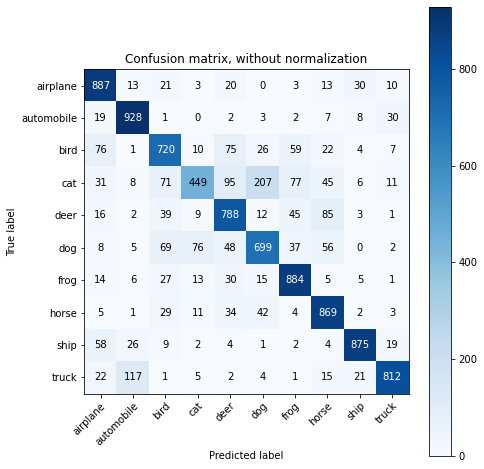

In [30]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix


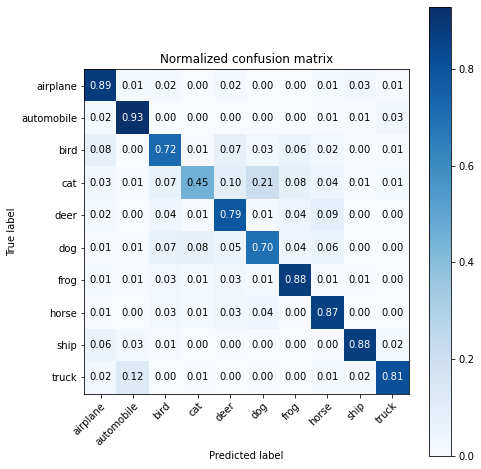

In [31]:

plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

In [33]:
y_pred_resnet=model_2.predict_classes(x_test)
y_true=np.argmax(y_test,axis=1)

#Compute the confusion matrix
confusion_mtx=confusion_matrix(y_true,y_pred_resnet)

Confusion matrix, without normalization


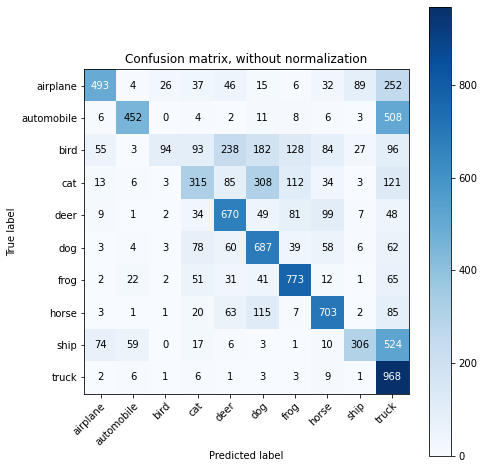

In [34]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred_resnet, classes=class_names,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix


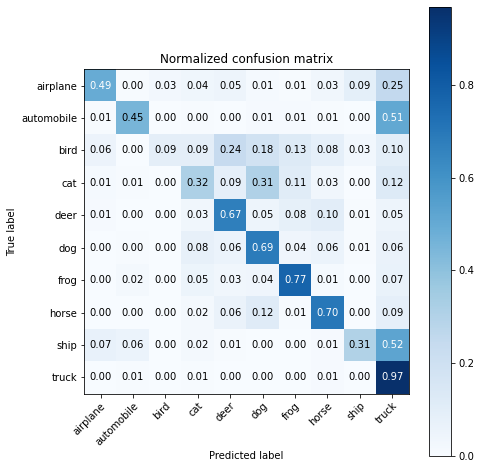

In [35]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_true, y_pred_resnet, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
# plt.show()

For both sets of these confusion matrices (it is much easier to compare effectivenesses when looking at the normalized matrices), the darker and closer to 1 the values on the diagonal are, the better these models performed when tested on the testing set of cifar10. From these results we can conclude that VGG19 performed with more accuracy of classification. With only 10 classifications it is clear how hard this process might be for a much larger dataset such as cifar100 or even the origional imagenet. As an addition to this section it would be interesting to compare more of these well-known and respected architecture models and weightings in the transfer. However, to answer our questions, this process was time consuming, but is relatively simple to repeat once you have taken the time we have to understand how to perform this transfer learning. It also credentials our results to some degree as we are using acredited models as the base model of our implementation rather than implementing our own from scratch. Compared to our performance in previous weeks to creating our own convolutional NN to learn on the cifar10 dataset, this method ourperformed the accuracy by about 10% in the VGG and 1-2% in ResNet50. 

## Implementation of AutoKeras for Cifar10

See next code for the implementation of AutoKeras on Cifar10. This will help us round out our initial questions by comparing our experience implementing these pre-established architectures to training an entire AutoML. 